In [148]:
#SETUP
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sqlite3
import numpy as np
from numpy import random

#load data (make sure you have downloaded database.sqlite)
with sqlite3.connect(r'C:/Users/ernest.chocholowski/Desktop/Datasets/Soccer/database.sqlite') as con:
    countries_df = pd.read_sql_query("SELECT * from Country", con)
    matches_df = pd.read_sql_query("SELECT * from Match", con)
    leagues_df = pd.read_sql_query("SELECT * from League", con)
    teams_df = pd.read_sql_query("SELECT * from Team", con)

In [149]:
bookies = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'GB', 'BS']
bookies_all = sorted([bookie+'H' for bookie in bookies]+[bookie+'D' for bookie in bookies]+[bookie+'A' for bookie in bookies])

In [150]:
#Check data integrity for all bookies
matches_df[bookies_all].count()

B365A    22592
B365D    22592
B365H    22592
BSA      14161
BSD      14161
BSH      14161
BWA      22575
BWD      22575
BWH      22575
GBA      14162
GBD      14162
GBH      14162
IWA      22520
IWD      22520
IWH      22520
LBA      22556
LBD      22556
LBH      22556
PSA      11168
PSD      11168
PSH      11168
SJA      17097
SJD      17097
SJH      17097
VCA      22568
VCD      22568
VCH      22568
WHA      22571
WHD      22571
WHH      22571
dtype: int64

In [151]:
#select_countries = ['England','France','Germany','Italy','Spain']
#countries_df = countries_df[countries_df.name.isin(select_countries)]
leagues_df = countries_df.merge(leagues_df, on='id', suffixes=('', '_y'))

In [152]:
#select relevant features
matches_df = matches_df[matches_df.league_id.isin(leagues.id)]
bookies = ['B365', 'BW', 'IW', 'LB', 'WH', 'VC', 'BS']
bookies_all = sorted([bookie+'H' for bookie in bookies]+[bookie+'D' for bookie in bookies]+[bookie+'A' for bookie in bookies])
feature_selection = ['id', 'country_id' ,'league_id', 'season', 'stage', 'date',
                     'match_api_id', 'home_team_api_id', 'away_team_api_id']+bookies_all
matches_df = matches_df[feature_selection]
matches_df.dropna(inplace=True)
matches_df.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,B365A,...,IWH,LBA,LBD,LBH,VCA,VCD,VCH,WHA,WHD,WHH
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,5.00,...,1.85,3.75,3.3,1.80,4.50,3.40,1.65,4.33,3.30,1.70
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,3.60,...,1.90,3.50,3.2,1.90,3.25,3.25,2.00,3.60,3.30,1.83
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,2.75,...,2.60,2.50,3.2,2.50,2.65,3.25,2.35,2.40,3.25,2.50
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,7.50,...,1.40,6.50,3.6,1.44,6.50,3.75,1.45,6.00,3.75,1.44
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1.65,...,4.00,1.72,3.4,4.00,1.65,3.40,4.50,1.70,3.40,4.20


In [156]:
matches_df.count()

id                  14063
country_id          14063
league_id           14063
season              14063
stage               14063
date                14063
match_api_id        14063
home_team_api_id    14063
away_team_api_id    14063
B365A               14063
B365D               14063
B365H               14063
BSA                 14063
BSD                 14063
BSH                 14063
BWA                 14063
BWD                 14063
BWH                 14063
IWA                 14063
IWD                 14063
IWH                 14063
LBA                 14063
LBD                 14063
LBH                 14063
VCA                 14063
VCD                 14063
VCH                 14063
WHA                 14063
WHD                 14063
WHH                 14063
entropy             14063
dtype: int64

In [157]:
from scipy.stats import entropy

def match_entropy(row):
    bookies = ['B365', 'BW', 'IW', 'LB', 'WH', 'VC', 'BS']
    odds_h = [row[bookie+'H'] for bookie in bookies]
    odds_d = [row[bookie+'D'] for bookie in bookies]
    odds_a = [row[bookie+'A'] for bookie in bookies]
    odds = [np.mean(odds_h), np.mean(odds_d), np.mean(odds_a)]
    #change odds to probability
    probs = [1/o for o in odds]
    #normalize to sum to 1
    norm = sum(probs)
    probs = [p/norm for p in probs]
    return entropy(probs)

#compute match entropy
matches_df['entropy'] = matches_df.apply(match_entropy,axis=1)

In [170]:
#compute mean entropy for every league in every season

entropy_means = matches_df.groupby(('season','league_id')).entropy.mean()

entropy_means = entropy_means.reset_index().pivot(index='season', columns='league_id', values='entropy')

entropy_means.columns = [leagues_df[leagues_df.id==league_id].name.values[0] \
                        for league_id in entropy_means.columns]

entropy_means.head(10)
entropy_means=entropy_means.drop(['Belgium', 'Scotland', 'Portugal'], axis=1)

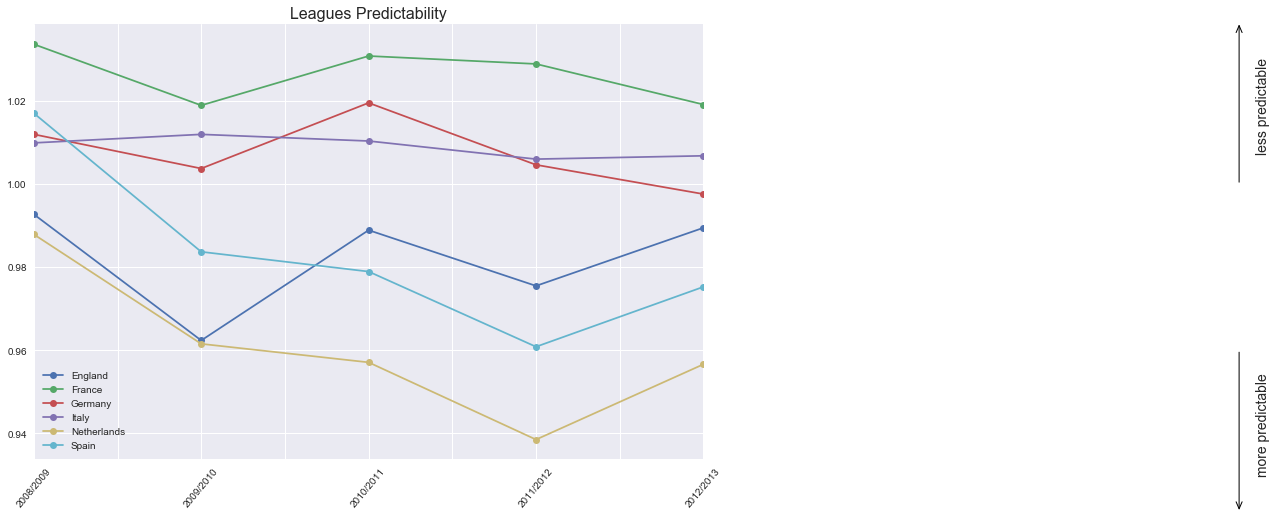

In [171]:
#plot graph
ax = entropy_means.plot(figsize=(12,8),marker='o')

#set title
plt.title('Leagues Predictability', fontsize=16)

#set ticks roatation
plt.xticks(rotation=50)

#keep colors for next graph
colors = [x.get_color() for x in ax.get_lines()]
colors_mapping = dict(zip(leagues_df.id, colors))

#remove x label
ax.set_xlabel('')

#locate legend 
plt.legend(loc='lower left')

#add arrows
ax.annotate('', xytext=(7.2, 1),xy=(7.2, 1.039),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('', xytext=(7.2, 0.96),xy=(7.2, 0.921),
            arrowprops=dict(facecolor='black',arrowstyle="->, head_length=.7, head_width=.3",linewidth=1), annotation_clip=False)

ax.annotate('less predictable', xy=(7.3, 1.028), annotation_clip=False,fontsize=14,rotation='vertical')
ax.annotate('more predictable', xy=(7.3, 0.952), annotation_clip=False,fontsize=14,rotation='vertical')